# Implementing a Declarative Node using the `ddn.pytorch.node` Module

Unlike the previous tutorials, in this notebook we use the [PyTorch](https://pytorch.org/) framework to implement a declarative node. For information on how to use PyTorch, see the [official documentation](https://pytorch.org/docs/stable/index.html) and [tutorials](https://pytorch.org/tutorials/). Here we will show how to implement a declarative node using the `ddn.pytorch.node` module to explore the behavior of the node and solve simple bi-level optimization problems.

## Example 1: Minimize the KL-divergence over the probability simplex

We consider the problem of minimizing the KL-divergence between the input $x$ and output $y$ subject to the output forming a valid probability vector (i.e., the elements of $y$ be positive and sum to one). We will assume strictly positive $x$. The problem can be written formally as

$$
\begin{array}{rll}
y =& \text{argmin}_u & - \sum_{i=1}^{n} x_i \log u_i \\
& \text{subject to} & \sum_{i=1}^{n} u_i = 1
\end{array}
$$
where the positivity constraint on $y$ is automatically satisfied by the domain of the log function.

A nice feature of this problem is that we can solve it in closed-form as
$$
y = \frac{1}{\sum_{i=1}^{n} x_i} x.
$$

However, we will only use this for verification and pretend for now that we do not have a closed-form solution. Instead we will make use of the `scipy.optimize` module to solve the problem via an iterative method. Deriving our deep declarative node from the `LinEqConstDeclarativeNode` class, we will need to implement three functions: the `objective` function, the `solve` function, and the `linear_constraint_parameters` function (the `gradient` function is already implemented for us).


In [1]:
import torch
import numpy as np
import scipy.optimize as opt
import sys
sys.path.append("../")
from ddn.pytorch.node import *
import warnings
warnings.filterwarnings('ignore')

# create the example node
class MinKL(LinEqConstDeclarativeNode):
    def __init__(self):
        super().__init__()

    def objective(self, x, y):
        """f(x, y) = -sum x*log(y)"""
        return -1.0 * torch.einsum('bn,bn->b', (x, y.log()))
    
    def linear_constraint_parameters(self, y):
        """Ay=d ==> sum(y) = 1"""
        A = y.new_ones(1, y.size(-1)) # 1xm
        d = y.new_ones(1) # 1
        return A, d
        
    def solve(self, x):
        """Solve the constrained optimization problem using scipy's built-in minimize function.
        Here we initialize the solver at the uniform distribution.
        """
        m = n = x.size(-1)
        u0 = np.ones((m,)) / m
        y = torch.zeros_like(x)
        # Loop over batch:
        for i, xi in enumerate(x):
            result = opt.minimize(lambda u: -1.0 * np.dot(xi.detach().numpy(), np.log(u)),
                                  u0,
                                  constraints={'type': 'eq', 'fun': lambda u: np.sum(u) - 1.0},
                                  bounds=opt.Bounds(1e-12, np.inf, keep_feasible=True),
                                  options={'maxiter': 100000, 'ftol': 1e-12})
            y[i, :] = torch.tensor(result.x)
        
        # The solve function must always return two arguments, the solution and context (i.e., cached values needed
        # for computing the gradient). In the case of linearly constrained problems we do not need the dual solution
        # in computing the gradient so we return None for context.
        return y, None

And now we test the node.

In [2]:
node = MinKL()
x = torch.rand(1, 5)
print("Input:\n{}".format(x.squeeze().numpy()))
print("Expected output:\n{}".format((x / x.sum(dim=-1, keepdim=True)).squeeze().numpy()))

y, _ = node.solve(x)
print("Actual output:\n{}".format(y.squeeze().numpy()))

Input:
[0.9920124  0.4909997  0.8832457  0.4305063  0.00693417]
Expected output:
[0.35382283 0.17512573 0.31502882 0.15354945 0.00247322]
Actual output:
[0.35382283 0.17512573 0.3150288  0.15354943 0.00247322]


We now plot the function and gradient sweeping the first component of the input $x_1$ from 0.1 to 10.0 while holding the other elements of $x$ constant.

<IPython.core.display.Javascript object>


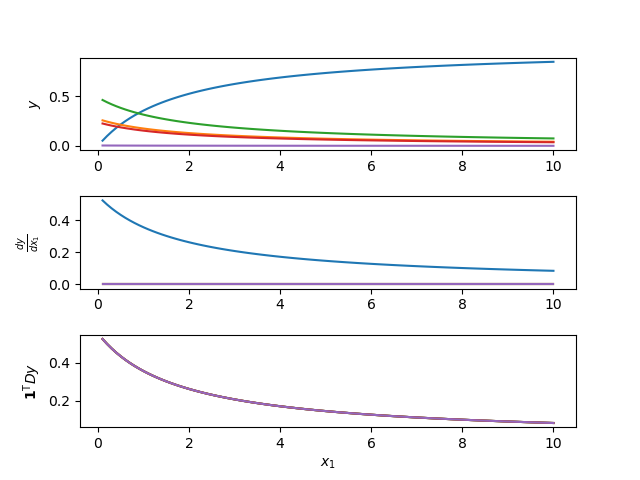

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

x1_data = torch.linspace(0.1, 10.0, 100)
x = x.detach() # Don't track computation graph
y_data = []
Dy_data = []
vjp_data = []
for x1 in x1_data:
    x_new = x.clone()
    x_new[0, 0] = x1
    x_new.requires_grad = True
    y, _ = torch.no_grad()(node.solve)(x_new) # Run node's forward pass
    y.requires_grad = True
    y_data.append(y.squeeze().detach().numpy())
    # Note that the jacobian function call is inefficient
    # and is used only for teaching and analysis purposes
    Dy_data.append(node.jacobian(x_new, y=y)[0][0,:,0].detach().numpy())
    vjp_data.append(node.gradient(x_new, y=y)[0][0,:].detach().numpy())

# Plot output y as x varies
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(x1_data, y_data)
plt.ylabel(r"$y$")

# Plot derivative dy/dx1 as x1 varies
# dy/dx = (I - y 1^T) / sum(xi)
# dy1/dx1 = (1 - y1) / sum(xi)
# dyi/dx1 = -yi / sum(xi), i > 1
plt.subplot(3, 1, 2)
plt.plot(x1_data, Dy_data)
#plt.ylabel(r"$Dy_{:,1}$")
plt.ylabel(r"$\frac{dy}{dx_1}$")

# Plot vector-Jacobian product as x1 varies
plt.subplot(3, 1, 3)
plt.plot(x1_data, vjp_data)
plt.xlabel(r"$x_1$");
plt.ylabel(r"$\mathbf{1}^\mathsf{T}Dy$")

fig.subplots_adjust(hspace=0.5)
plt.show()


### Bi-level optimization

Now let's see whether we can use the node within a bi-level optimization problem. We will attempt to learn an input $x$ that results in an output $y$ with smallest norm-squared. Moreover, we will regularize the norm of $x$ to be close to 10. Given our understanding of KL-divergence this should learn a vector $x$ that is a constant multiple of the ones vector (i.e., all elements of $x$ should be the same). Let's see what happens.

Found x = [5.339799  3.2433367 5.042678  5.8650203 0.810371 ] with norm 9.98
Results in y = [0.26302868 0.1597608  0.24839303 0.2889001  0.03991738]


<IPython.core.display.Javascript object>


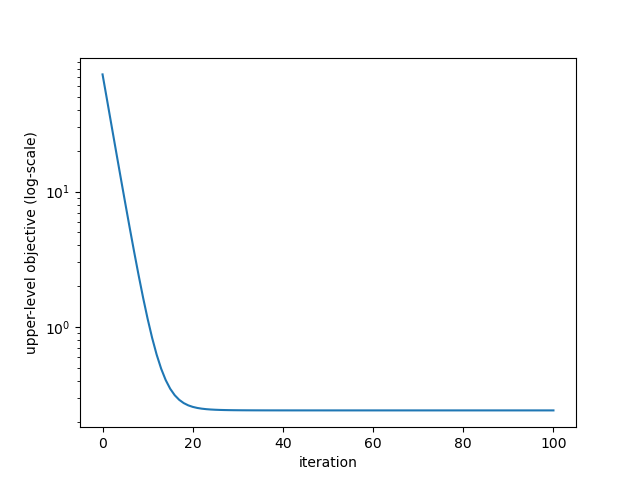

Found x = [5.020233  3.5881119 5.291182  5.568644  1.570348 ] with norm 9.98
Results in y = [0.23862104 0.17054963 0.25149974 0.26468801 0.07464156]


<IPython.core.display.Javascript object>


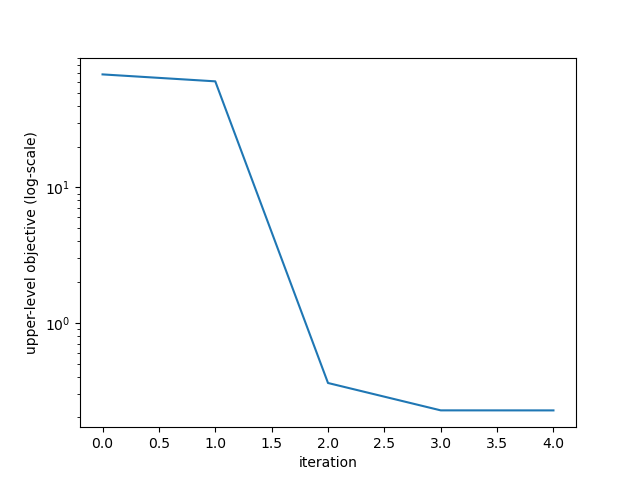

In [4]:
# define the upper-level objective
def J(x, y=None):
    """Computes our upper-level objective given both x and y."""
    if y is None:
        y, _ = torch.no_grad()(node.solve)(x)
    return ((y.norm(dim=-1)) ** 2 + (x.norm(dim=-1) - 10.0) ** 2).mean()

kl_problem = MinKL()
kl_declarative_layer = DeclarativeLayer(kl_problem)

# Solve using gradient descent:
learning_rate = 0.1
x = torch.rand(1, 5, requires_grad=True)
history = [J(x).detach().numpy()]
for i in range(100):
    y = kl_declarative_layer(x)
    z = J(x, y)
    z.backward()
    x_new = x - learning_rate * x.grad
    x = x_new.detach().requires_grad_(True)
    history.append(J(x).detach().numpy())

y, _ = torch.no_grad()(node.solve)(x)
x_np = x.detach().squeeze().numpy()
y_np = y.detach().squeeze().numpy()
print("Found x = {} with norm {:0.2f}".format(x_np, np.sqrt(np.dot(x_np, x_np))))
print("Results in y = {}".format(y_np))

fig = plt.figure()
plt.semilogy(history)
plt.ylabel("upper-level objective (log-scale)"); plt.xlabel("iteration")
plt.show()

# Solve using LBFGS:
x = torch.rand(1, 5, requires_grad=True)
history = []
optimizer = torch.optim.LBFGS([x], lr=1, max_iter=100)
def reevaluate():
    optimizer.zero_grad()
    y = kl_declarative_layer(x)
    z = J(x, y)
    z.backward()
    history.append(z.clone().detach().numpy())
    return z
optimizer.step(reevaluate)

y, _ = torch.no_grad()(node.solve)(x)
x_np = x.detach().squeeze().numpy()
y_np = y.detach().squeeze().numpy()
print("Found x = {} with norm {:0.2f}".format(x_np, np.sqrt(np.dot(x_np, x_np))))
print("Results in y = {}".format(y_np))

fig = plt.figure()
plt.semilogy(history)
plt.ylabel("upper-level objective (log-scale)"); plt.xlabel("iteration")
plt.show()

## Example 2: Minimize a robust (pseudo-Huber) distance

We consider the problem of minimizing the distance between the input $x$ and output $y$ using the robust pseudo-Huber penalty function. The problem can be written formally as
$$
\begin{equation}
y = \text{argmin}_u \sum_{i=1}^{n} \phi^\text{pseudo}(u - x_i; \alpha)
\end{equation}
$$
where the pseudo-Huber penalty function is given by
$$
\begin{equation}
  \phi^{\text{pseudo}}(z; \alpha) = \alpha^2 \left( \sqrt{1 + \left(\frac{z}{\alpha}\right)^2} - 1 \right).
\end{equation}
$$

Deriving our deep declarative node from the `AbstractDeclarativeNode` class, we will need to implement two functions: the `objective` function, and the `solve` function. However, we will also provide a `gradient` function to compare the generic gradient result with an efficient hand-coded gradient that makes use of the structure of the problem.

In [5]:
import torch
import numpy as np
import sys
sys.path.append("../")
from ddn.pytorch.node import *
import warnings
warnings.filterwarnings('ignore')

class GlobalPseudoHuberPool2d(AbstractDeclarativeNode):
    """"""
    def __init__(self):
        super().__init__()
        
    def objective(self, x, alpha, y):
        alpha2 = alpha * alpha
        z = y.unsqueeze(-1).unsqueeze(-1) - x
        phi = alpha2 * (torch.sqrt(1.0 + torch.pow(z, 2) / alpha2) - 1.0)
        return phi.sum(dim=(-2,-1)) # b

    def solve(self, x, alpha):
        x = x.detach()
        y = x.mean([-2, -1]).clone().requires_grad_()
        y = self._runOptimisation(x, alpha, y)
        y = y.detach()
        z = (y.unsqueeze(-1).unsqueeze(-1) - x).clone()
        ctx = {'z': z}
        return y, ctx
    
    def _runOptimisation(self, x, alpha, y):
        with torch.enable_grad():
            opt = torch.optim.LBFGS([y],
                                    lr=1, # Default: 1
                                    max_iter=100, # Default: 20
                                    max_eval=None, # Default: None
                                    tolerance_grad=1e-05, # Default: 1e-05
                                    tolerance_change=1e-09, # Default: 1e-09
                                    history_size=100, # Default: 100
                                    line_search_fn=None # Default: None, Alternative: "strong_wolfe"
                                    )
            def reevaluate():
                opt.zero_grad()
                f = self.objective(x, alpha, y).sum() # sum over batch elements
                f.backward()
                return f
            opt.step(reevaluate)
        return y

    def gradient(self, x, alpha, y=None, v=None, ctx=None):
        """Override base class to compute the analytic gradient of the optimal solution."""
        if y is None:
            y, ctx = torch.no_grad()(self.solve)(x, alpha)
        if v is None:
            v = torch.ones_like(y)
        z = ctx['z'] # b x n1 x n2
        w = torch.pow(1.0 + torch.pow(z, 2) / (alpha * alpha), -1.5)
        w_sum = w.sum(dim=-1, keepdim=True).sum(dim=-2, keepdim=True).expand_as(w)
        Dy_at_x = torch.where(w_sum.abs() <= 1e-9, torch.zeros_like(w), w.div(w_sum))  # b x n1 x n2
        return torch.einsum('b,bmn->bmn', (v, Dy_at_x)), None

And now we test the node.

In [6]:
node = GlobalPseudoHuberPool2d()
batch_size = 3
input_size = (6, 6)
x = torch.randn(batch_size, *input_size, dtype=torch.double, requires_grad=True)
alpha = torch.tensor([0.5], dtype=torch.double, requires_grad=False)
y, _ = torch.no_grad()(node.solve)(x, alpha)

print("Input:\n{}".format(x[0,...].squeeze().detach().numpy())) # First batch element only
print("Output:\n{}".format(y[0,...].squeeze().detach().numpy())) # First batch element only

Input:
[[-0.4667697  -0.52619248 -1.07193743  1.04831224 -0.22465619 -0.59044202]
 [-1.08354777 -0.98739476  0.33434853 -0.59620501 -2.34761377  0.01040023]
 [ 0.11500972 -2.08864992 -0.08655447  0.26853892  0.76453993 -1.08362776]
 [-0.29986127  0.59363175 -1.67359848 -0.2061471  -0.34897808  0.97474372]
 [ 0.60784929 -2.4551684   1.67716509 -0.14165272 -2.14101913  1.22173836]
 [-0.70341297 -0.96687235 -0.94881823  0.09091704  1.21728568 -0.42055629]]
Output:
-0.3257707761514061


We now plot the function and gradient sweeping the first component of the input $x_1$ from -10.0 to 10.0 while holding the other elements of $x$ constant.

<IPython.core.display.Javascript object>


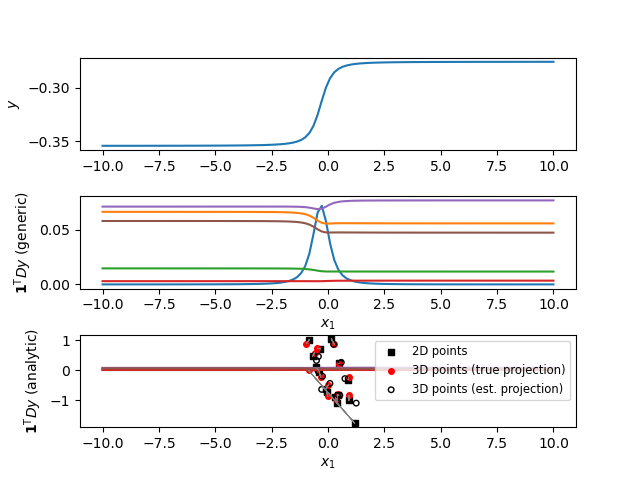

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt

x1_data = torch.linspace(-10.0, 10.0, 110)
x = x.detach() # Don't track computation graph
y_data = []
vjp_data = []
vjp2_data = []
for x1 in x1_data:
    x_new = x.clone()
    x_new[:, 0, 0] = x1
    x_new.requires_grad = True
    y, ctx = torch.no_grad()(node.solve)(x_new, alpha)
    y.requires_grad = True
    y_data.append(y[0,...].squeeze().detach().numpy()) # First batch element only
    vjp_data.append(super(type(node), node).gradient(x_new, alpha, y=y, ctx=ctx)[0][0,0,:].detach().numpy()) # First 6 components
    vjp2_data.append(node.gradient(x_new, alpha, y=y, ctx=ctx)[0][0,0,:].detach().numpy()) # First 6 components
    
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(x1_data, y_data)
plt.ylabel(r"$y$")

plt.subplot(3, 1, 2)
plt.plot(x1_data, vjp_data)
plt.xlabel(r"$x_1$"); plt.ylabel(r"$\mathbf{1}^\mathsf{T}Dy$ (generic)")

plt.subplot(3, 1, 3)
plt.plot(x1_data, vjp2_data)
plt.xlabel(r"$x_1$"); plt.ylabel(r"$\mathbf{1}^\mathsf{T}Dy$ (analytic)")

fig.subplots_adjust(hspace=0.5)
plt.show()


## Example 3: Minimize a PnP objective function

We consider the problem of minimizing the weighted reprojection error between a set of corresponding 3D and 2D points $\{p_i, q_i \}_{i=1}^n$ by varying the rigid transformation parameters $y$ applied to the 3D points. Here the transformation parameters consist of an angle-axis rotation vector concatenated with a translation vector. The problem can be written formally as
$$
y = \text{argmin}_u \sum_{i=1}^{n} w_i \| \pi(p_i, u) - q_i \|_2^2
$$
where the projection $\pi(\cdot)$ is given by
$$
\pi(p, u) = h(K (R(u) p + t(u)))
$$
with intrinsic camera parameters $K$, rotation $R$, translation $t$, and map from homogeneous-to-Cartesian coordinates $h$, where $h(x) = [x_1 / x_3, x_2 / x_3]$.

Deriving our deep declarative node from the `AbstractDeclarativeNode` class, we will need to implement two functions: the `objective` function, and the `solve` function. For this class, we use the `solvePnPRansac` function from the Python OpenCV library.

In [8]:
import torch
import numpy as np
import sys
import cv2 as cv
from math import degrees
sys.path.append("../")
from ddn.pytorch.node import *
import ddn.pytorch.geometry_utilities as geo

import warnings
warnings.filterwarnings('ignore')

class PnP(AbstractDeclarativeNode):
    """Declarative PnP layer"""
    def __init__(self,
                 ransac_threshold=0.1,
                 ransac_max_iterations=1000,
                ):
        super().__init__()
        self.ransac_threshold = ransac_threshold
        self.ransac_max_iterations = ransac_max_iterations
        
    def objective(self, p, q, w, K, y):
        """Weighted reprojection error"""
        p_projected = geo.project_points_by_theta(p, y, K)
        squared_error = torch.sum((p_projected - q) ** 2, dim=-1)
        w = torch.nn.functional.relu(w) # Enforce non-negative weights
        return torch.einsum('bn,bn->b', (w, squared_error))
    
    def solve(self, p, q, w, K=None):
        p = p.detach()
        q = q.detach()
        w = w.detach()
        K = K.detach() if K is not None else None
        y = self._initialise_transformation(p, q, w, K).requires_grad_()
        y = self._run_optimisation(p, q, w, K, y=y)
        return y.detach(), None
    
    def _ransac_p3p(self, p, q, K, threshold, max_iterations):
        p_np = p.cpu().numpy()
        q_np = q.cpu().numpy()
        y = q.new_zeros(q.size(0), 6)
        if K is None:
            K_np = np.float32(np.array([[1.0, 0.0, 0.0],
                                        [0.0, 1.0, 0.0],
                                        [0.0, 0.0, 1.0]]))
        for i in range(q_np.shape[0]): # loop over batch
            if K is not None:
                K_np = np.float32(np.array([[K[i, 0], 0.0, K[i, 2]],
                                            [0.0, K[i, 1], K[i, 3]],
                                            [0.0, 0.0, 1.0]]))
            retval, rvec, tvec, inliers = cv.solvePnPRansac(
                p_np[i, :, :], q_np[i, :, :], K_np, None,
                iterationsCount=max_iterations,
                reprojectionError=threshold,
                flags=cv.SOLVEPNP_EPNP)
            if rvec is not None and tvec is not None and retval:
                rvec = torch.as_tensor(rvec, dtype=q.dtype, device=q.device).squeeze(-1)
                tvec = torch.as_tensor(tvec, dtype=q.dtype, device=q.device).squeeze(-1)
                if torch.isfinite(rvec).all() and torch.isfinite(tvec).all():
                    y[i, :3] = rvec
                    y[i, 3:] = tvec
        return y
    
    def _initialise_transformation(self, p, q, w, K):
        return self._ransac_p3p(p, q, K, self.ransac_threshold, self.ransac_max_iterations)

    def _run_optimisation(self, *xs, y):
        with torch.enable_grad():
            opt = torch.optim.LBFGS([y],
                                    lr=1.0,
                                    max_iter=1000,
                                    max_eval=None,
                                    tolerance_grad=1e-40,
                                    tolerance_change=1e-40,
                                    history_size=100,
                                    line_search_fn="strong_wolfe"
                                    )
            def reevaluate():
                opt.zero_grad()
                f = self.objective(*xs, y=y).sum() # sum over batch elements
                f.backward()
                return f
            opt.step(reevaluate)
        return y

Now we test the node with 15 random 2D-3D point pairs, random camera parameters, significant additive Gaussian noise, and a single outlier correspondence. We should expect poor results for PnP algorithms when there are outliers, but perhaps we can learn to identify such outliers?

In [9]:
node = PnP()
b = 1
n = 15

# Generate camera parameters:
y_true = torch.randn(b, 6, dtype=torch.double)
R_true = geo.angle_axis_to_rotation_matrix(y_true[..., :3])
t_true = y_true[..., 3:]

# Generate image points, then assign depths:
xy = 2.0 * torch.rand(b, n, 2, dtype=torch.double) - 1.0 # [-1, 1]
z = 2.0 * torch.rand(b, n, 1, dtype=torch.double) + 1.0 # [1, 3]
p_transformed = torch.cat((z * xy, z), dim=-1)
p = torch.einsum('brs,bms->bmr', (R_true.transpose(-2,-1), p_transformed - t_true.unsqueeze(-2))) # Inverse transform
q = xy.clone()
q = q + 0.1 * torch.randn(b, n, 2, dtype=torch.double) # add noise
q[:, 0:1, :] = torch.randn(b, 1, 2, dtype=torch.double) # add outliers

# Generate weights (uniform):
w = torch.ones(b, n, dtype=torch.double) # bxn
w = w.div(w.sum(-1).unsqueeze(-1))

# Run solver:
y, _ = torch.no_grad()(node.solve)(p, q, w)
R = geo.angle_axis_to_rotation_matrix(y[..., :3])
t = y[..., 3:]

# Compute objective function value:
reproj_error = torch.no_grad()(node.objective)(p, q, w, K=None, y=y)
reproj_error_true = torch.no_grad()(node.objective)(p, q, w, K=None, y=y_true)

# Compute transformation errors:
error_rotation = (0.5 * ((R * R_true).sum(dim=(-2, -1)) - 1.0)).acos()
error_translation = (t - t_true).norm(dim=-1)

# Save original data:
p_orig = p.clone()
q_orig = q.clone()
w_orig = w.clone()
y_orig = y.clone()

print("True Output:\n{}".format(y_true[0,...].squeeze().detach().numpy())) # First batch element only
print("Est. Output:\n{}".format(y[0,...].squeeze().detach().numpy())) # First batch element only
print("True Reprojection Error: {:0.4f}".format(reproj_error_true[0,...].squeeze().detach().numpy())) # First batch element only
print("Est. Reprojection Error: {:0.4f}".format(reproj_error[0,...].squeeze().detach().numpy())) # First batch element only
print("Rotation Error: {:0.2f} degrees".format(degrees(error_rotation[0,...].squeeze().detach().numpy()))) # First batch element only
print("Translation Error: {:0.2f}".format(error_translation[0,...].squeeze().detach().numpy())) # First batch element only


True Output:
[-1.62378436  0.73980198  0.31346055  0.41089292 -0.12090749 -0.29069035]
Est. Output:
[-1.61455358  1.05806323  0.73130802 -0.67501939 -0.23519071  0.13729917]
True Reprojection Error: 0.5053
Est. Reprojection Error: 0.4362
Rotation Error: 26.75 degrees
Translation Error: 1.17


It is clear that even a single outlier can play havoc with PnP estimation. We can visualize this by plotting the 2D points and projected 3D points, using the true and estimated transformation parameters. We link the putative 2D and 3D correspondences with a line, to make the outlier correspondence clear.

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt

q_np = q.numpy()
p_proj_true_np = geo.project_points_by_theta(p, y_true).numpy()
p_proj_np = geo.project_points_by_theta(p, y).numpy()
for i in range(q_np[0, :, 0].shape[0]):
   plt.plot([q_np[0, :, 0], p_proj_true_np[0, :, 0]], [q_np[0, :, 1], p_proj_true_np[0, :, 1]], color='gray', linewidth=0.5)  
plt.scatter(q_np[0, :, 0], q_np[0, :, 1], s=16, c='k', alpha=1.0, marker='s', label='2D points')
plt.scatter(p_proj_true_np[0, :, 0], p_proj_true_np[0, :, 1], s=16, c='r', alpha=1.0, marker='o', label='3D points (true projection)')
plt.scatter(p_proj_np[0, :, 0], p_proj_np[0, :, 1], s=16, facecolors='none', edgecolors='k', alpha=1.0, marker='o', label='3D points (est. projection)')
plt.legend(fontsize='small')

plt.show()

### Bi-level optimization

Now let's try to learn weights $w$ that attenuate the effect of the outlier correspondences, including those that occur due to noise. Our upper-level objective function will be a weighted sum of rotation and translation errors, given that we know the true camera pose. We expect the outlier correspondence to be downweighted, as well as some of the noisier points.

In [11]:
# Define the upper-level objective:
def J(p, q, w, y=None):
    """Compute sum of angular and positional camera errors"""
    if y is None:
        y, _ = torch.no_grad()(node.solve)(p, q, w)
    R = geo.angle_axis_to_rotation_matrix(y[..., :3])
    t = y[..., 3:]
    max_dot_product = 1.0 - 1e-7
    error_rotation = (0.5 * ((R * R_true).sum(dim=(-2, -1)) - 1.0)
                     ).clamp_(-max_dot_product, max_dot_product).acos()
    error_translation = (t - t_true).norm(dim=-1)
    #print("rot: {:0.2f}, trans: {:0.6f}".format(degrees(error_rotation[0,...]), error_translation[0,...]))
    return (error_rotation + 0.25 * error_translation).mean(), error_rotation, error_translation

# Reset parameters:
w = w_orig.clone().detach().requires_grad_()
y = y_orig.clone()

# Form a declarative layer:
pnp_declarative_layer = DeclarativeLayer(node)

loss, error_rotation, error_translation = J(p, q, w, y)
history_loss = [loss]
history_rot = [degrees(error_rotation[0, ...])] # First batch element only
history_tran = [error_translation[0, ...]] # First batch element only

# Solve using LBFGS optimizer:
optimizer = torch.optim.LBFGS([w], lr=1, max_iter=50, line_search_fn="strong_wolfe")
def reevaluate():
    optimizer.zero_grad()
    y = pnp_declarative_layer(p, q, w, None)
    z, error_rotation, error_translation = J(p, q, w, y)
    z.backward()
    history_loss.append(z.clone().detach().numpy())
    history_rot.append(degrees(error_rotation[0, ...])) # First batch element only
    history_tran.append(error_translation[0, ...].detach().numpy()) # First batch element only
    return z
optimizer.step(reevaluate)

w = torch.nn.functional.relu(w) # Enforce non-negativity

y, _ = torch.no_grad()(node.solve)(p, q, w)
R = geo.angle_axis_to_rotation_matrix(y[..., :3])
t = y[..., 3:]
reproj_error = torch.no_grad()(node.objective)(p, q, w, K=None, y=y)
error_rotation = (0.5 * ((R * R_true).sum(dim=(-2, -1)) - 1.0)).acos()
error_translation = (t - t_true).norm(dim=-1)

p_np = p.detach().numpy()
q_np = q.detach().numpy()
w_np = w.detach().numpy()
y_np = y.detach().numpy()

print("Found w = {}".format(w_np[0, ...]))
print("Reprojection Error: {:0.4f}".format(reproj_error[0,...].squeeze().detach().numpy()))
print("Rotation Error: {:0.2f} degrees".format(degrees(error_rotation[0,...].squeeze().detach().numpy())))
print("Translation Error: {:0.6f}".format(error_translation[0,...].squeeze().detach().numpy()))
print("True Output: {}".format(y_true[0,...].squeeze().detach().numpy())) # First batch element only
print("Est. Output: {}".format(y[0,...].squeeze().detach().numpy())) # First batch element only

Found w = [0.         0.         0.16760816 0.42739386 0.15355314 0.69845509
 0.8081744  0.         0.06774719 0.82655466 0.         0.
 0.2892864  0.12176888 0.29851299]
Reprojection Error: 0.0617
Rotation Error: 0.03 degrees
Translation Error: 0.081506
True Output: [-1.62378436  0.73980198  0.31346055  0.41089292 -0.12090749 -0.29069035]
Est. Output: [-1.62351821  0.73995382  0.31307098  0.34635285 -0.15621975 -0.25560696]


And now we plot the learning curves.

<IPython.core.display.Javascript object>


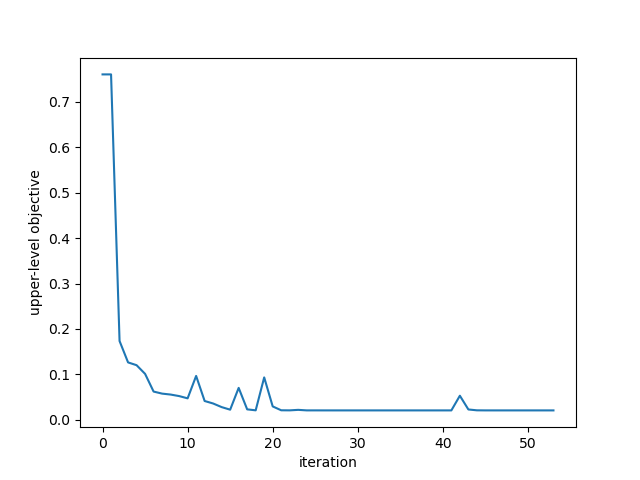

<IPython.core.display.Javascript object>


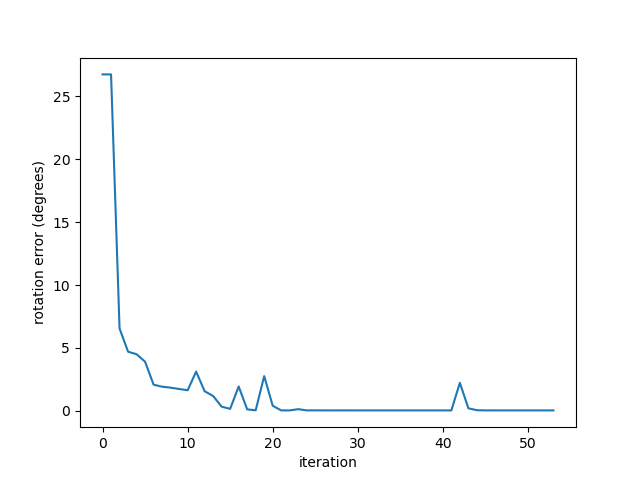

<IPython.core.display.Javascript object>


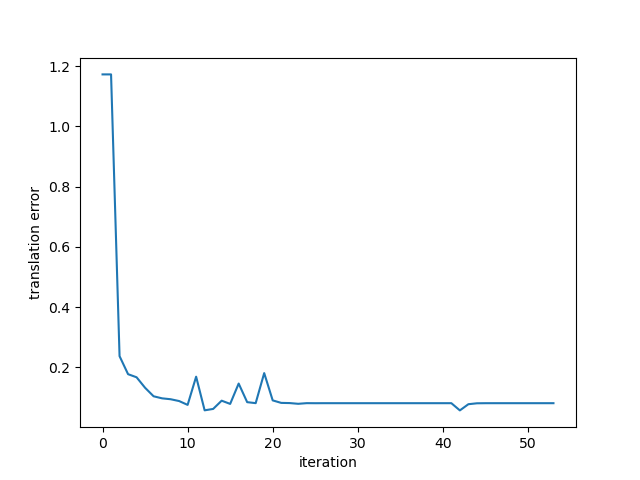

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history_loss)
plt.ylabel("upper-level objective"); plt.xlabel("iteration")
plt.show()

fig = plt.figure()
plt.plot(history_rot)
plt.ylabel("rotation error (degrees)"); plt.xlabel("iteration")
plt.show()

fig = plt.figure()
plt.plot(history_tran)
plt.ylabel("translation error"); plt.xlabel("iteration")
plt.show()

We can visualize the results by plotting the 2D points and projected 3D points. We scale the points by the estimated weight, and replace points with weight $\approx 0$ with crosses to indicate outlier correspondences.

<IPython.core.display.Javascript object>


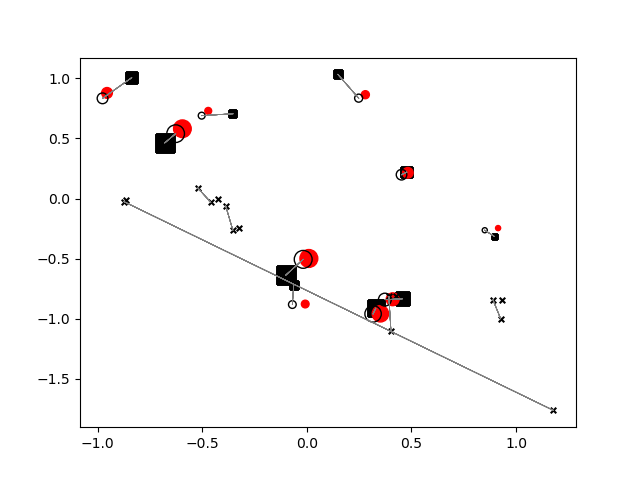

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()

p_proj_true_np = geo.project_points_by_theta(p.detach(), y_true).numpy()
p_proj_np = geo.project_points_by_theta(p.detach(), y).numpy()

for i in range(q_np[0, :, 0].shape[0]):
    # plt.plot([q_np[0, :, 0], p_proj_true_np[0, :, 0]], [q_np[0, :, 1], p_proj_true_np[0, :, 1]], color='gray', linewidth=0.5)
    plt.plot([q_np[0, :, 0], p_proj_np[0, :, 0]], [q_np[0, :, 1], p_proj_np[0, :, 1]], color='gray', linewidth=0.5)  

    plt.scatter(q_np[0, :, 0], q_np[0, :, 1], s=200.*w_np[0,...], c='k', alpha=1.0, marker='s', label='2D points')
plt.scatter(p_proj_true_np[0, :, 0], p_proj_true_np[0, :, 1], s=200.*w_np[0,...], c='r', alpha=1.0, marker='o', label='3D points (true projection)')
plt.scatter(p_proj_np[0, :, 0], p_proj_np[0, :, 1], s=200.*w_np[0,...], facecolors='none', edgecolors='k', alpha=1.0, marker='o', label='3D points (est. projection)')

# Plot identified outliers separately:
plt.scatter(q_np[0, w_np[0,...] < 1e-3, 0], q_np[0, w_np[0,...] < 1e-3, 1], s=16, c='k', alpha=1.0, marker='x', label='2D points (outliers)')
plt.scatter(p_proj_true_np[0, w_np[0,...] < 1e-3, 0], p_proj_true_np[0, w_np[0,...] < 1e-3, 1], s=16, c='k', alpha=1.0, marker='x', label='3D points (outliers)')
plt.scatter(p_proj_np[0, w_np[0,...] < 1e-3, 0], p_proj_np[0, w_np[0,...] < 1e-3, 1], s=16, c='k', alpha=1.0, marker='x', label='3D points (outliers)')
#plt.legend(fontsize='small')
plt.show()